# Preprocessing pipeline [dev]

The goal of this pipeline is to produce preprocessed data that is clean enough to be further analyzed in ERP or connectivity analyses. This pipeline is semi-automatic; manual steps are not necessarily required, but it is advised to revisit the cleaned epochs. ICA components have to be selected manually.

## Outline
Considering the remarks [here](https://autoreject.github.io/faq.html#should-i-apply-ica-first-or-autoreject-first)


- bandpass filter 0.5 - 45Hz
- create fixed length epochs 
- preliminary bad epoch rejection
- fit ICA on cleaned data segments
- mark components based on visual inspection
- apply ICA on epochs
- run [autoreject](https://www.sciencedirect.com/science/article/abs/pii/S1053811917305013) 
- find and interpolate bad sensors



## Install package requirements

Can be ignored if requirements are already installed.

In [ ]:
!pip install -r ../requirements.txt

## Import packages


```%matplotlib qt``` is the recommended backend for interactive visualization (can be slower); 
switch to ```%matplotlib inline``` for (faster) static plots

In [1]:
import os
from pathlib import Path
from ipyfilechooser import FileChooser

from eeg_preprocessing.preprocessing import *
from eeg_preprocessing.utils.events import get_events_from_raw, create_epochs_from_events
from eeg_preprocessing.utils.io_raw import read_raw

from matplotlib import pyplot as plt
%matplotlib qt

In [ ]:
import sys
sys.path.append('..')

## Load raw data

In [2]:
# Set base path to EEG data
base_path = '/Volumes/crnl-memo-hd/TMS_rewiring/Raw_data'

# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
interim_path = os.path.join(base_path, folder_name)

# Use the widget to navigate to the experiment folder path and select an EEG file 
fc = FileChooser(base_path)
fc.filter_pattern = '*.vhdr'

display(fc)

FileChooser(path='/Volumes/crnl-memo-hd/TMS_rewiring/Raw_data', filename='', title='HTML(value='', layout=Layo…

In [3]:
# Load selected file
raw = read_raw(raw_file_path=fc.selected, add_info=True)
print(raw.info)

Extracting parameters from /Volumes/crnl-memo-hd/TMS_rewiring/Raw_data/15_L/Day3/EEG/15_L_Day3.vhdr...
Setting channel info structure...
<Info | 12 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 condition: L
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 fid: 15_L_Day3
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2020-10-28 09:28:19 UTC
 nchan: 64
 num_day: 3
 projs: []
 sfreq: 500.0 Hz
 subject: 15
>


## Event processing

In [37]:
# Extract triggers from raw instance
events = get_events_from_raw(raw)

# Uncomment to show events
events.head(20)

resting_event_names = events.loc[events['event'].str.contains('rs_'), 'event'].tolist()
asrt_event_names = events.loc[events['event'].str.contains('asrt_'), 'event'].tolist()

## Cut raw data and create epochs based on triggers

### Create epochs

- bandpass filter the continuous data (0.5 - 45 Hz)
- create fixed length epochs (1 second)

In [133]:
epochs = create_epochs_from_events(raw=raw, events=events)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 sec)

Not setting metadata
Not setting metadata
4020 matching events found
No baseline correction applied
0 projection items activated
Loading data for 4020 events and 500 original time points ...
0 bad epochs dropped


In [25]:
resting_event_names

['rs_3_1', 'rs_3_2']

## Run preprocessing

Preprocess the resting periods together.


### 1.1. Preliminary epoch rejection

In [39]:
epochs_faster = prepare_epochs_for_ica(epochs=epochs)

Preliminary epoch rejection: 
Bad by amplitude:
	[  78  131  137  151  314  832  833  856  964  965 1528 1651 2261 2522
 2659 2672 2969 3127 3266 3445 3622 3623 3732 3768 3931 3936 3937 3965
 3995]
Bad by deviation:
	[  41   49   53   54   68   77   78  132  133  136  138  139  141  142
  148  150  151  164  165  171  186  187  189  190  240  305  313  314
  315  316  409  410  626  645  646  832  833  839  840  964  965 1529
 1632 1780 1781 2018 2070 2522 2523 2542 2543 2658 2659 2660 2930 3191
 3513 3514 3589 3622 3623 3624 3785 3826 3827 3830 3844 3845 3873 3874
 3886 3887 3889 3906 3937 3938 3966 3967 3968 3974 3975 3982 4009 4010
 4011 4017 4018]
Bad by variance:
	[  37   78  131  132  137  140  151  171  187  208  304  312  313  314
  803  833  840  856  964  965 1115 1528 1632 1651 1665 1781 1887 1888
 2261 2334 2379 2429 2454 2469 2476 2522 2542 2577 2589 2659 2662 2666
 2672 2685 2758 2840 2841 2883 2893 2948 2969 2996 3057 3127 3156 3265
 3266 3268 3277 3381 3442 3445 3495 35

### 1.2. Run ICA

In [17]:
ica = run_ica(epochs=epochs_faster)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 32 components
 


/Users/weian/venv/eeg-preprocessing/lib/python3.7/site-packages/mne/preprocessing/infomax_.py:192: RuntimeWarning: overflow encountered in exp
  y = 1.0 / (1.0 + np.exp(-u))


Fitting ICA took 183.2s.
Not setting metadata
Not setting metadata
3868 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


Not setting metadata
Not setting metadata
1082 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


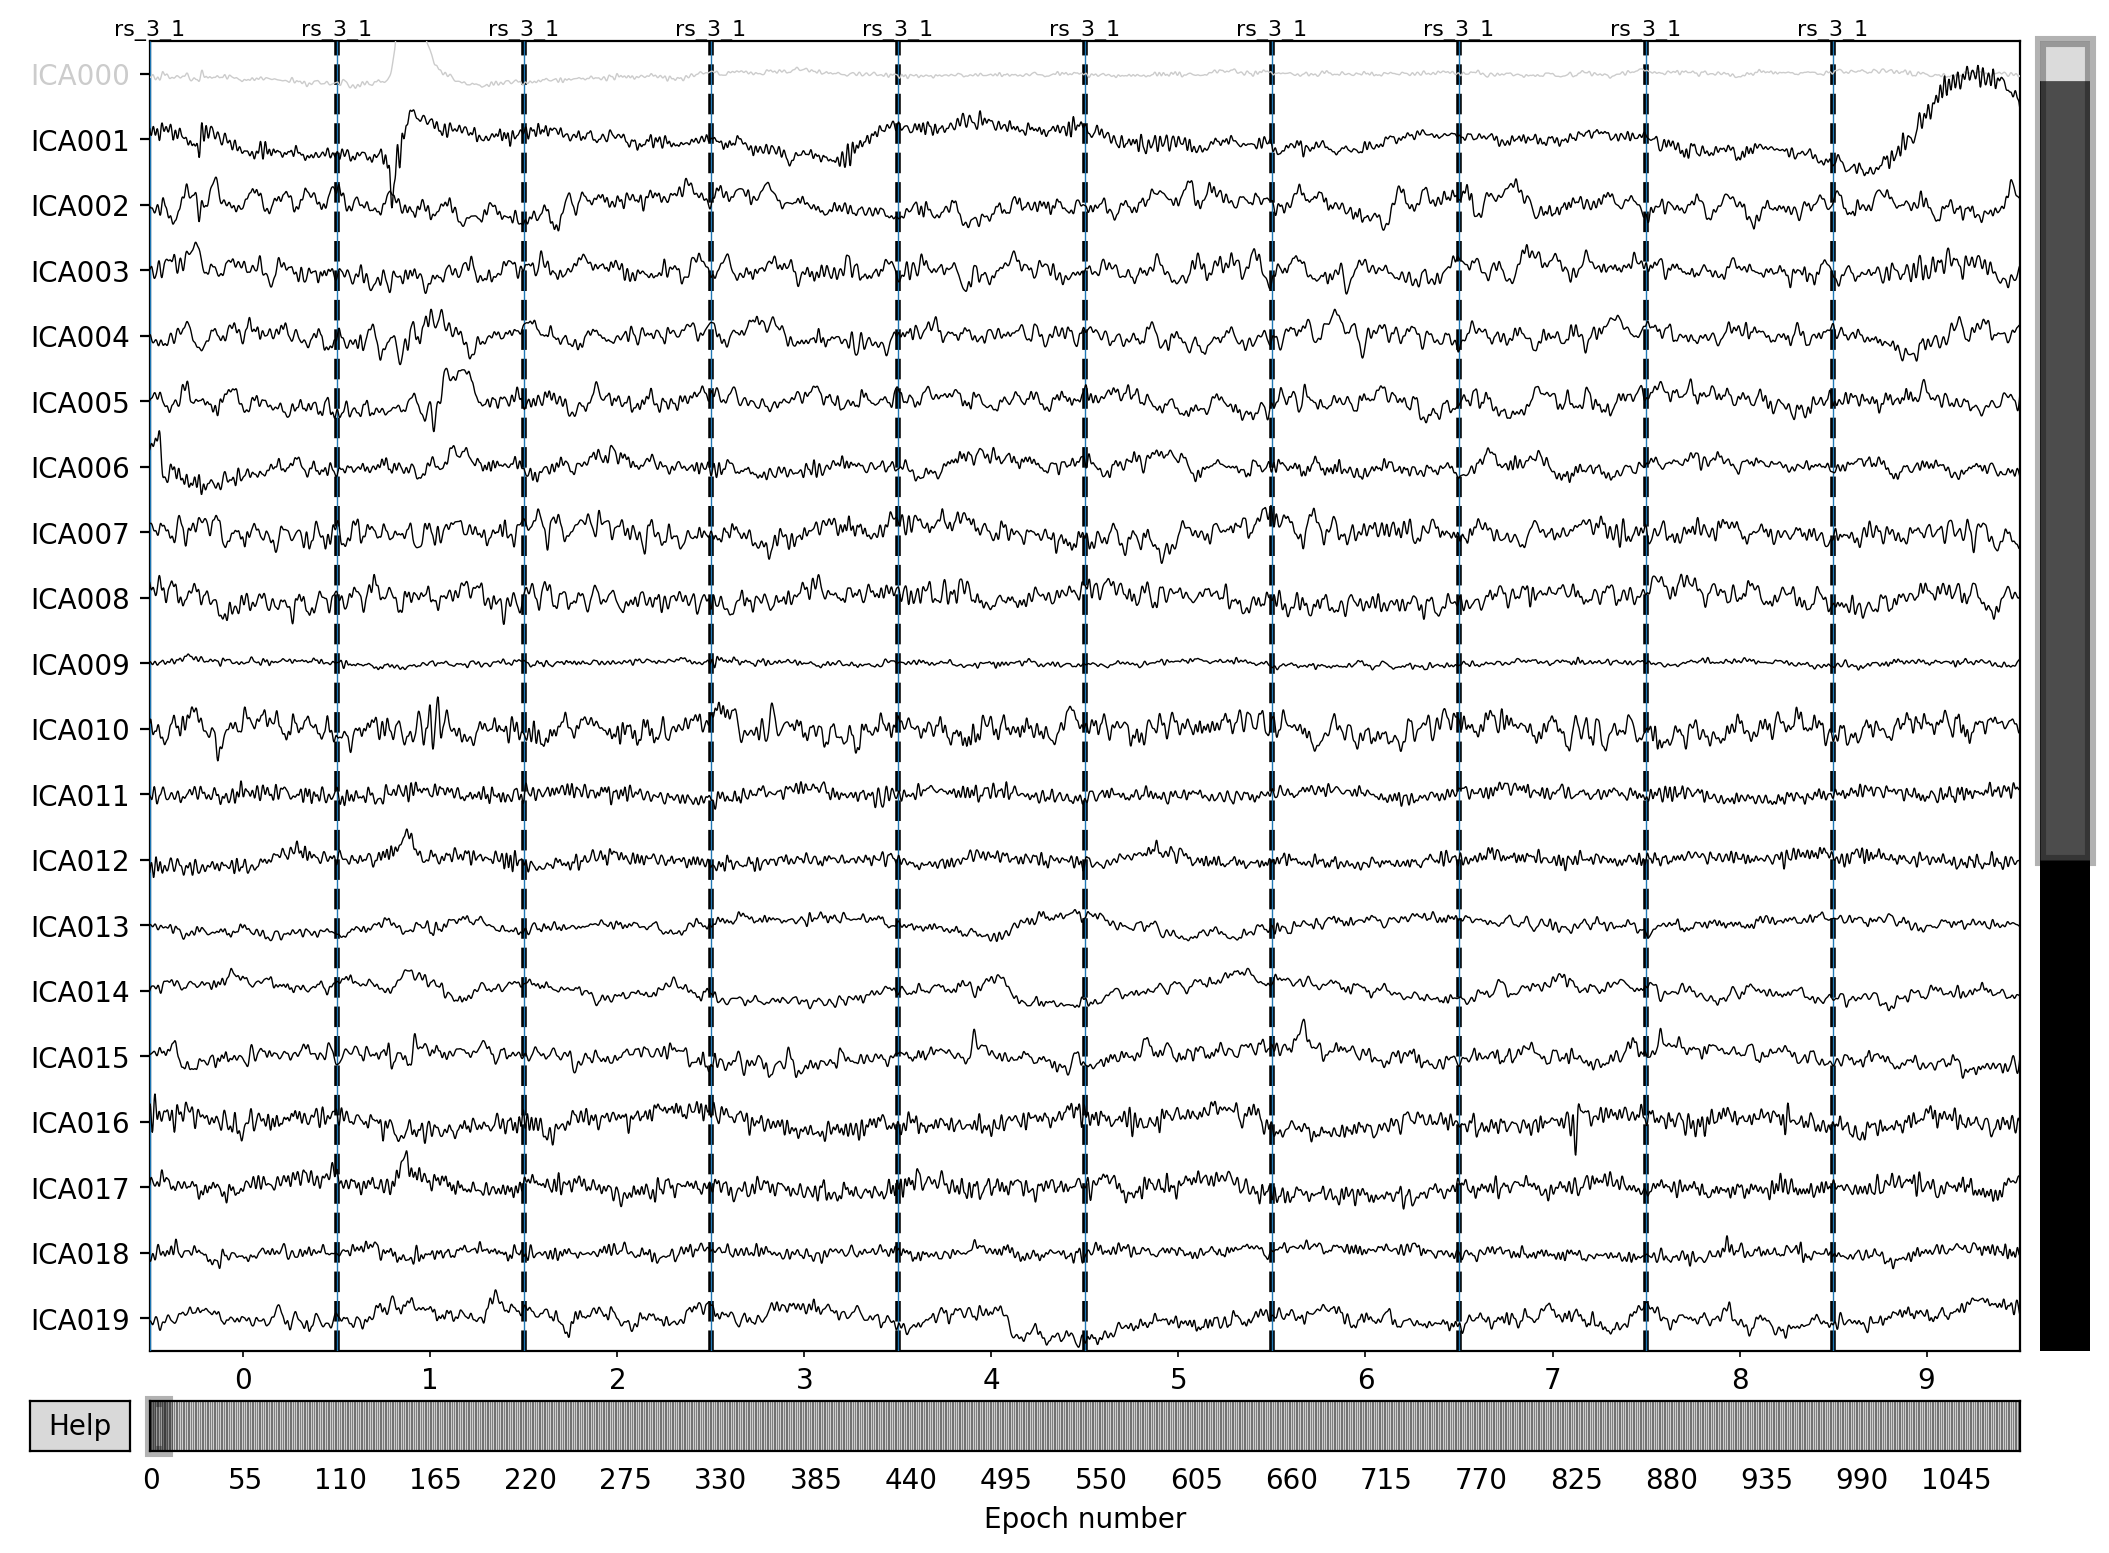

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
1082 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
1082 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [35]:
# Visualize components on epochs
# Subset epochs to reduce execution time
subset = resting_event_names + [asrt_event_names[0]]
# Exclude components by selecting them, right click on component name to visulize source:
ica.plot_sources(epochs_faster[subset], start=0, stop=10)

In [47]:
# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_faster)
epochs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


### 1.3. Visualize ICA cleaned epochs (optional)

This step can be repeated after each preprocessing step, or you can also do a final inspection at the end. 

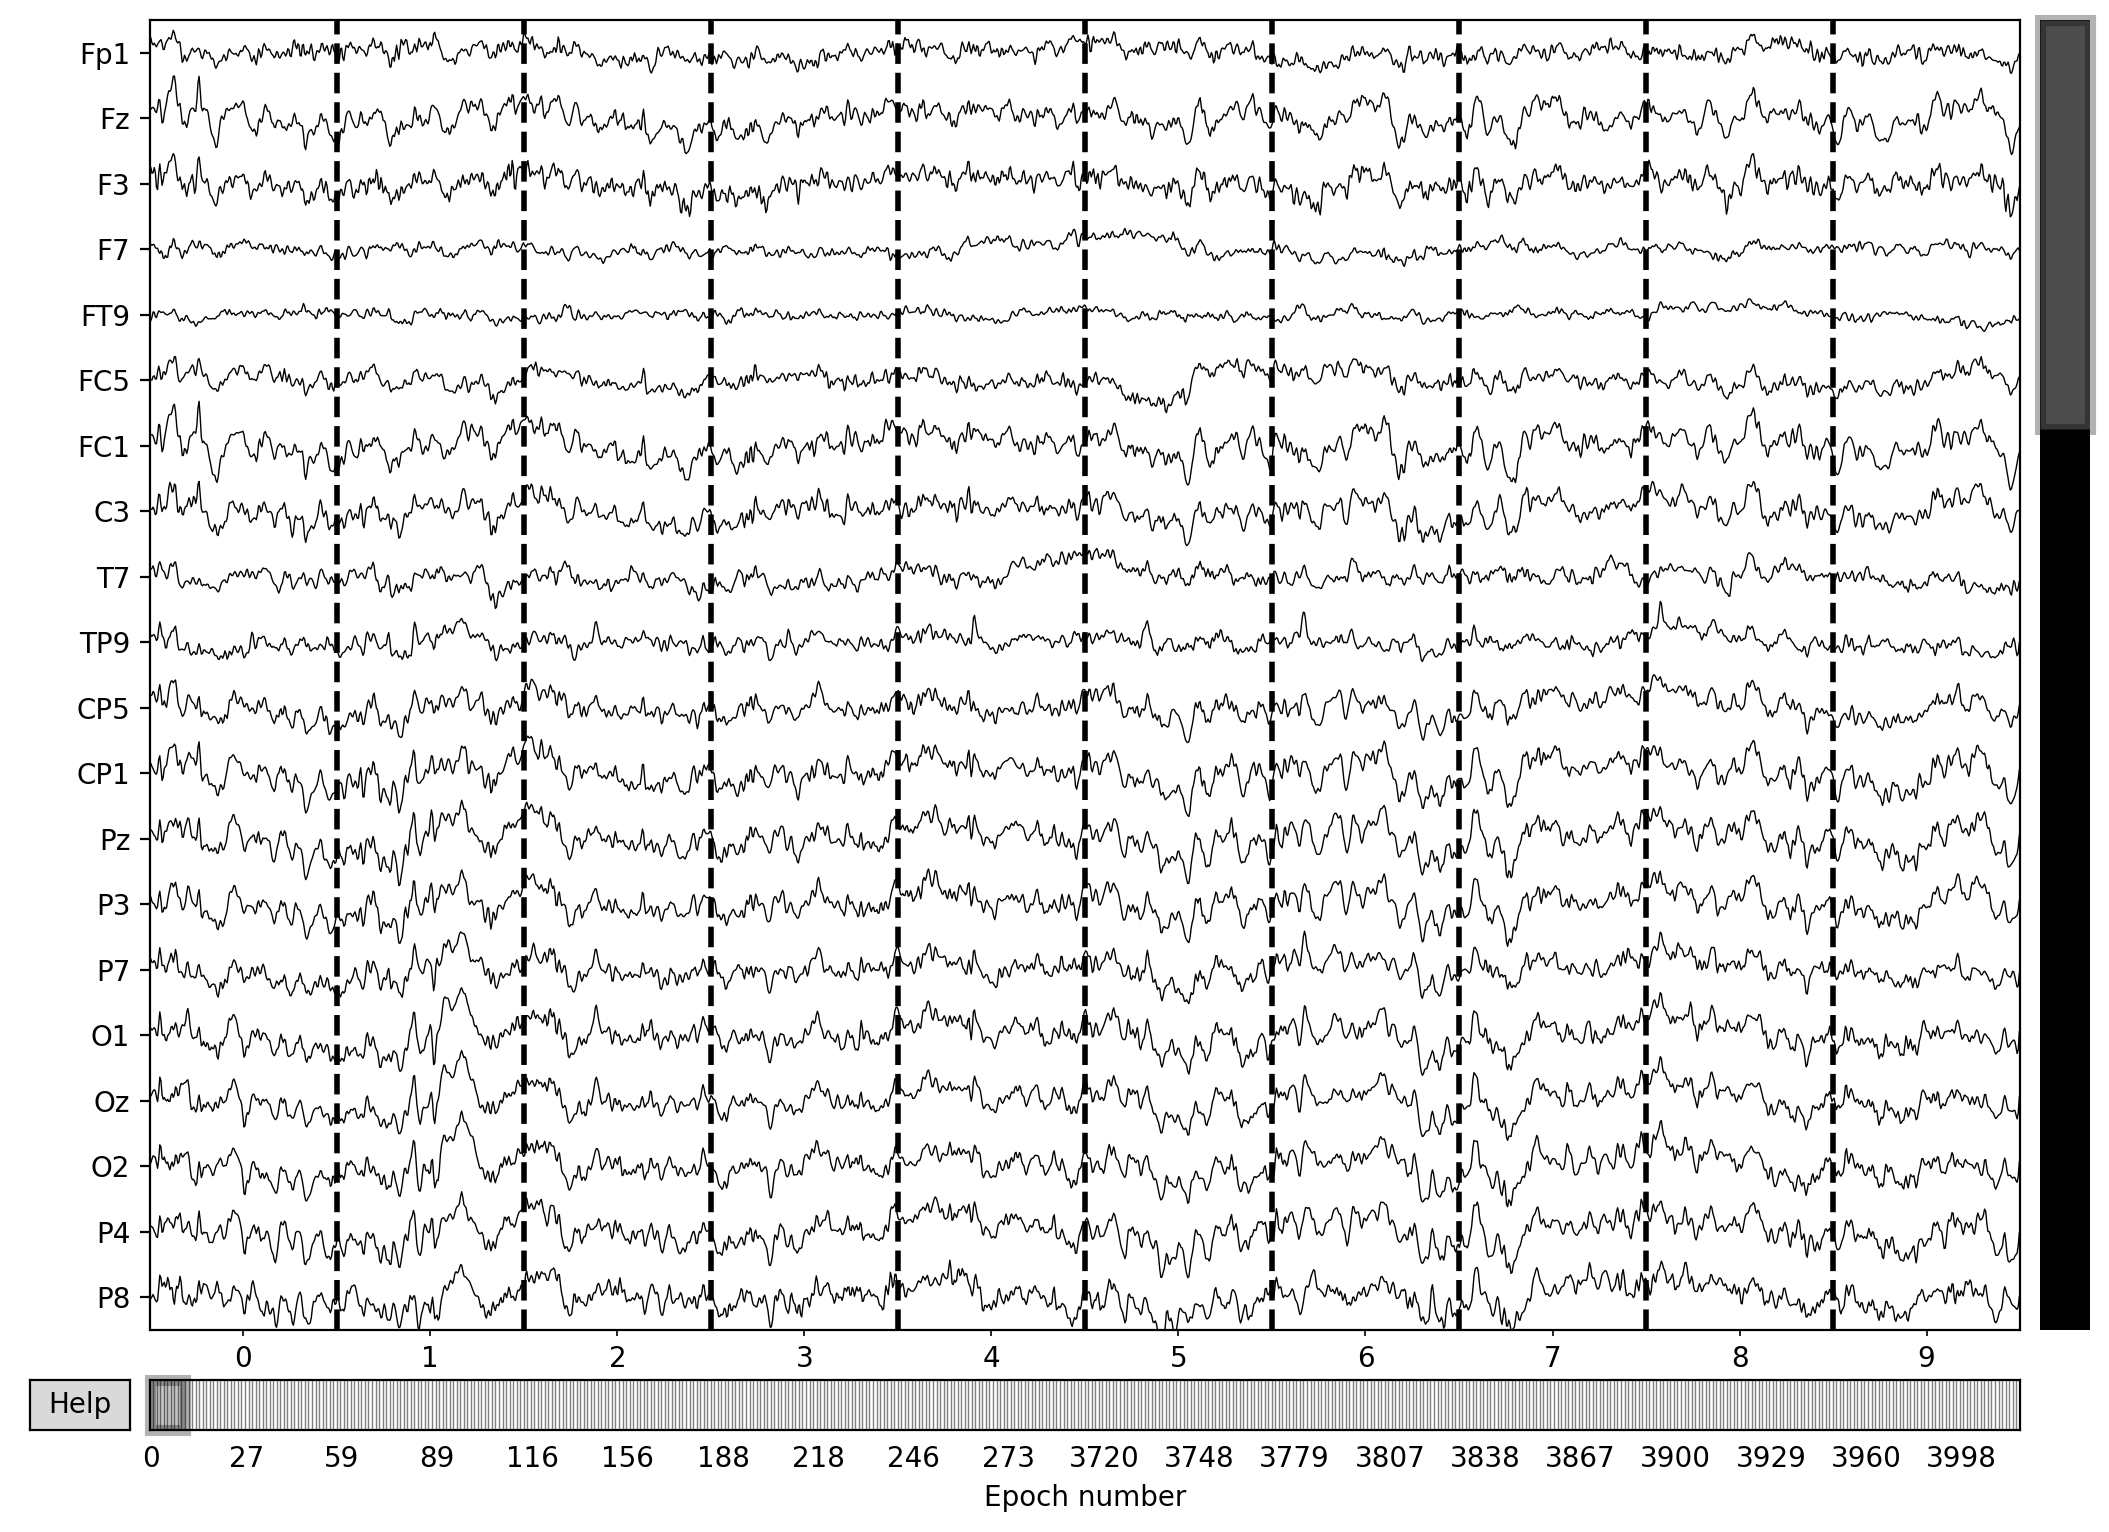

Dropped 0 epochs: 
Channels marked as bad: none


In [48]:
epochs_faster[resting_event_names].plot(n_epochs=10,
                                        scalings={'eeg': 20e-6},
                                        title=raw.info['fid'])

Not setting metadata
Not setting metadata
270 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


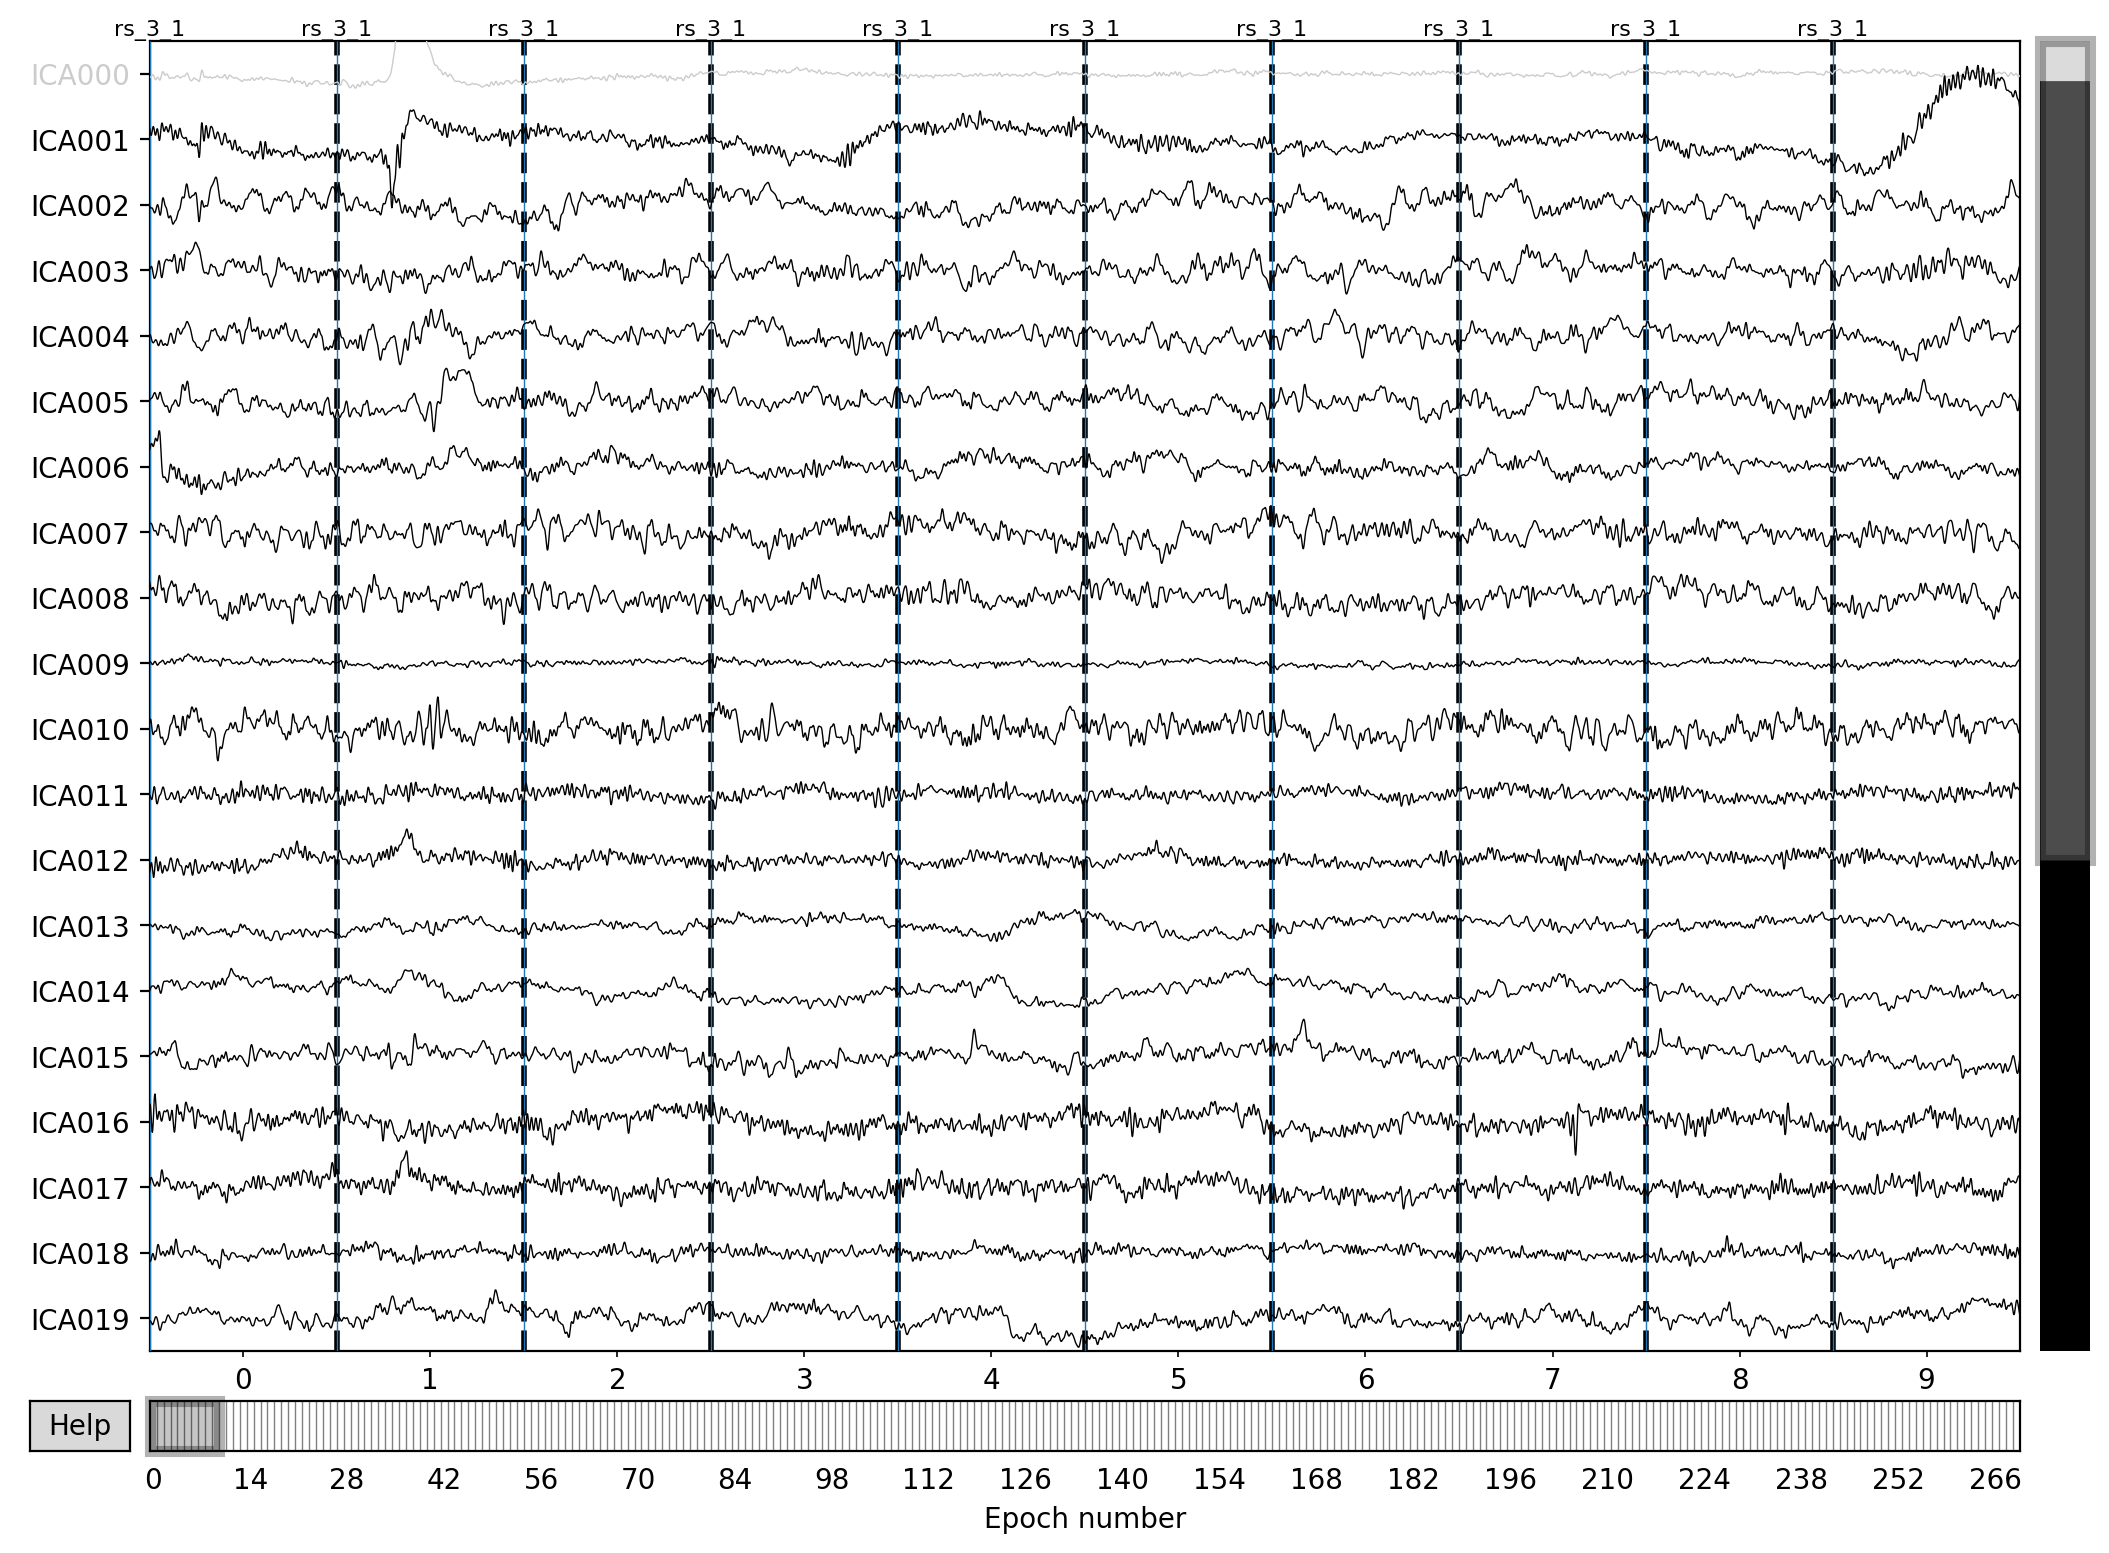

In [18]:
# Optional

# If you found a component that should have been excluded but it wasn't you can exclude it here:
ica.plot_sources(epochs_faster['rs_3_1'], start=0, stop=10)

In [ ]:
# Optional

# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_rs_faster)
epochs_rs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

### 1.4. Save cleaned epochs (recommended)

In [50]:
# Create path to epoch files
interim_epochs_path = os.path.join(interim_path, raw.info['condition'], 'epochs')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Save ICA cleaned epochs 
fid = epochs_faster.info['fid']
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_faster.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [68]:
len(epochs_faster)

3857

### 2.1. Run autoreject

In [ ]:
import random
subset = random.sample(set(np.arange(0, n_epochs, 1)), int(n_epochs * 0.25))

In [69]:
ar = run_autoreject(epochs_faster, n_jobs=4, subset=True)

Fitting autoreject on epochs: 
Running autoreject on ch_type=eeg








Estimated consensus=0.80 and n_interpolate=32


In [70]:
reject_log = ar.get_reject_log(epochs_faster)

epochs_autoreject = epochs_faster.copy().drop(reject_log.bad_epochs, reason='AUTOREJECT')

Dropped 0 epochs: 


In [106]:
epochs_autoreject.info

<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 condition: L
 custom_ref_applied: False
 description: n_components: 3
 dig: 64 items (64 EEG)
 fid: 15_L_Day3
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2020-10-28 09:28:19 UTC
 nchan: 64
 num_day: 3
 projs: []
 sfreq: 500.0 Hz
 subject: 15
>

In [115]:
idx = np.where(np.count_nonzero(reject_log.labels, axis=1) > epochs_autoreject.info['nchan']/2)[0].tolist()

# Plot just the bad epochs!
if idx: 
    epochs_autoreject[idx].plot(n_epochs=10,
                                scalings={'eeg': 20e-6},
                                n_channels=32)

Dropped 0 epochs: 
Channels marked as bad: none


In [116]:
epochs_autoreject.drop(idx, reason='AUTOREJECT')

Dropped 76 epochs: 513, 605, 612, 724, 725, 1081, 1082, 1279, 1286, 1311, 1328, 1435, 1439, 1474, 1556, 1595, 1632, 1656, 1667, 1668, 1711, 1785, 1796, 1828, 1918, 1954, 1955, 1956, 1986, 2007, 2178, 2196, 2210, 2223, 2227, 2270, 2286, 2323, 2395, 2466, 2502, 2507, 2556, 2577, 2653, 2662, 2664, 2667, 2695, 2724, 2801, 2810, 2814, 2826, 2848, 2858, 2916, 2929, 3043, 3067, 3166, 3172, 3245, 3385, 3402, 3411, 3473, 3474, 3475, 3510, 3551, 3552, 3626, 3714, 3784, 3785


<Epochs |  3781 events (all good), 0 - 0.998 sec, baseline off, ~923.2 MB, data loaded,
 'asrt_3_1': 545
 'asrt_3_2': 561
 'asrt_3_3': 546
 'asrt_3_4': 538
 'asrt_3_5': 529
 'asrt_3_6': 536
 'rs_3_1': 270
 'rs_3_2': 256>

In [ ]:
del epochs_rs

In [ ]:
# save clean epochs
fid = epochs_autoreject_rs.info['fid']
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject_rs.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

### 3. Run ransac

In [117]:
epochs_ransac = run_ransac(epochs_autoreject)
# set average reference
#epochs_ransac_rs.set_eeg_reference()

Iterating epochs ...


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:   48.7s remaining:  3.7min
[Parallel(n_jobs=11)]: Done   4 out of  11 | elapsed:   48.8s remaining:  1.4min
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed:   51.7s remaining:   43.1s
[Parallel(n_jobs=11)]: Done   8 out of  11 | elapsed:   53.0s remaining:   19.9s
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:  1.2min finished


[Done]
Interpolating bad channels
    Automatic origin fit: head of radius 85.0 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 6 sensors


In [119]:
epochs_ransac_rs.info

<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 condition: L
 custom_ref_applied: False
 description: n_components: 3 interpolated: TP9, FT10, AF7, FT8, F6, AF8
 dig: 64 items (64 EEG)
 fid: 15_L_Day3
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2020-10-28 09:28:19 UTC
 nchan: 64
 num_day: 3
 projs: []
 sfreq: 500.0 Hz
 subject: 15
>

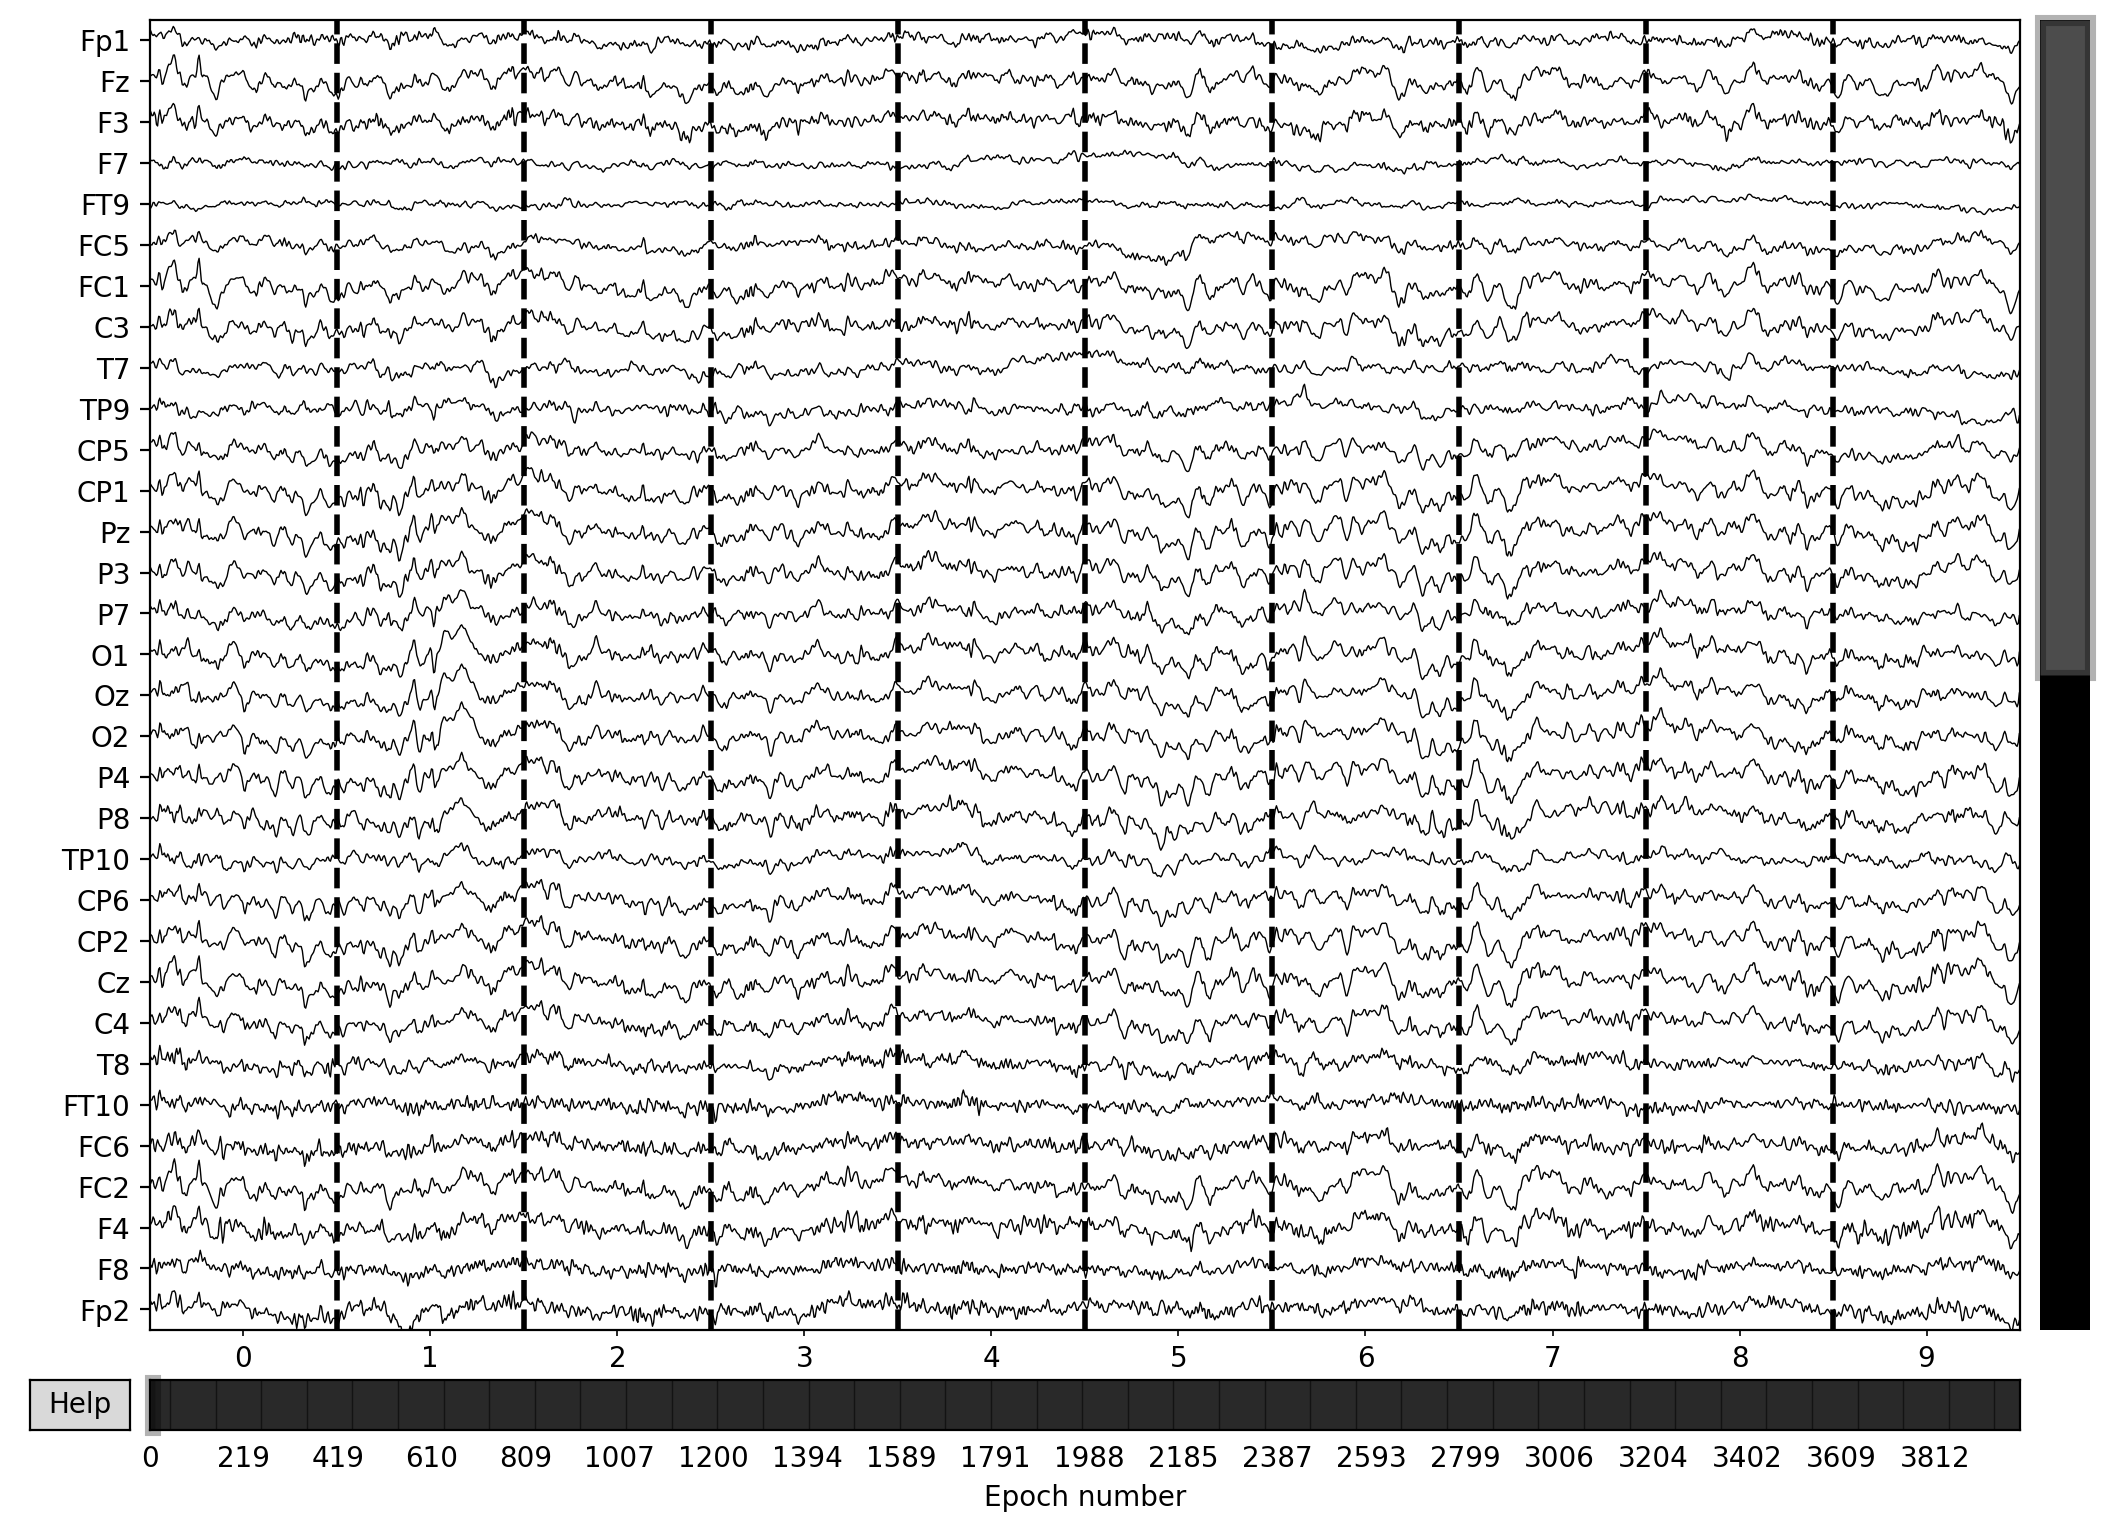

Dropped 0 epochs: 
Channels marked as bad: none


In [123]:
epochs_ransac_rs.plot(n_epochs=10,
                     n_channels=32, 
                      group_by='position',
                     scalings={'eeg': 20e-6})

### 4. Final visual inspection

Mark epochs that should be dropped, select electrodes that should be interpolated etc.

In [ ]:
epochs_ransac_rs.plot(n_epochs=10,
                      event_id={f'rs_{raw.info["num_day"]}_1':1,
                                f'rs_{raw.info["num_day"]}_2':2},
                      events=epochs_ransac_rs.events,
                      scalings={'eeg': 20e-6},
                      event_color={1: 'tab:green', 2: 'tab:blue'})

In [ ]:
if epochs_ransac_rs.info['bads']:
    bads_str = ', '.join(epochs_ransac_rs.info['bads'])
    epochs_ransac_rs.interpolate_bads()
    epochs_ransac_rs.info.update(description=epochs_ransac_rs.info['description'] + ', interpolated: ' + bads_str)

epochs_ransac_rs.set_eeg_reference()

In [129]:
epochs_ransac_rs.event_id

{'asrt_3_1': 91,
 'asrt_3_2': 93,
 'asrt_3_3': 95,
 'asrt_3_4': 97,
 'asrt_3_5': 99,
 'asrt_3_6': 101,
 'rs_3_1': 83,
 'rs_3_2': 87}

In [135]:
start_times = [epochs.events[idx][0] / raw.info['sfreq'] for idx, value in enumerate(epochs_ransac_rs.drop_log) if value]


In [136]:
start_times

[78.482,
 82.482,
 90.482,
 94.482,
 95.482,
 109.482,
 118.482,
 119.482,
 172.482,
 173.482,
 174.482,
 177.482,
 178.482,
 179.482,
 180.482,
 181.482,
 182.482,
 183.482,
 189.482,
 191.482,
 192.482,
 205.482,
 206.482,
 212.482,
 227.482,
 228.482,
 230.482,
 231.482,
 249.482,
 281.482,
 397.508,
 398.508,
 405.508,
 406.508,
 407.508,
 408.508,
 409.508,
 502.508,
 503.508,
 729.318,
 803.318,
 859.752,
 860.752,
 861.752,
 862.752,
 869.752,
 1023.408,
 1024.408,
 1059.408,
 1088.408,
 1089.408,
 1090.408,
 1095.408,
 1096.408,
 1112.408,
 1303.722,
 1304.722,
 1554.148,
 1573.148,
 1574.148,
 1868.172,
 1875.172,
 1900.172,
 1917.172,
 2173.76,
 2177.76,
 2212.76,
 2213.76,
 2214.76,
 2354.514,
 2375.514,
 2394.514,
 2395.514,
 2408.514,
 2482.442,
 2506.442,
 2517.442,
 2518.442,
 2561.442,
 2572.442,
 2573.442,
 2699.934,
 2710.934,
 2741.934,
 2742.934,
 2743.934,
 2745.934,
 2910.954,
 3213.612,
 3214.612,
 3215.612,
 3216.612,
 3246.612,
 3266.612,
 3268.612,
 3536.1,
 3

In [139]:

raw.annotations.append(onset=start_times,
                       duration=[1.0] * len(start_times),
                       description='BAD_auto')

<Annotations | 8235 segments: BAD_auto (239), New Segment/ (1), Stimulus/S ...>

In [141]:
events

start_time  event_id     event sequence  end_time  duration
9        393.508        91  asrt_3_1        A   507.944   114.436
272      549.214        91  asrt_3_1        A   663.682   114.468
535      705.318        91  asrt_3_1        A   819.870   114.552
801      856.752        91  asrt_3_1        A   971.222   114.470
1065    1012.408        91  asrt_3_1        A  1127.042   114.634
1335    1209.722        93  asrt_3_2        B  1324.324   114.602
1602    1375.454        93  asrt_3_2        B  1490.124   114.670
1870    1537.148        93  asrt_3_2        B  1651.818   114.670
2139    1705.682        93  asrt_3_2        B  1820.218   114.536
2404    1862.172        93  asrt_3_2        B  1976.640   114.468
2671    2125.760        95  asrt_3_3        A  2240.294   114.534
2937    2297.514        95  asrt_3_3        A  2412.098   114.584
3203    2460.442        95  asrt_3_3        A  2574.926   114.484
3466    2636.934        95  asrt_3_3        A  2751.486   114.552
3730    2825.954        95  asrt_3_3        A  2940.690   114.736
4002    3206.612        97  asrt_3_4        B  3321.364   114.752
4273    3361.416        97  asrt_3_4        B  3475.984   114.568
4540    3531.100        97  asrt_3_4        B  3645.652   114.552
4805    3724.526        97  asrt_3_4        B  3839.060   114.534
5070    3885.636        97  asrt_3_4        B  4000.304   114.668
5337    4148.146        99  asrt_3_5        A  4262.698   114.552
5601    4306.086        99  asrt_3_5        A  4420.520   114.434
5865    4489.568        99  asrt_3_5        A  4604.170   114.602
6131    4660.070        99  asrt_3_5        A  4774.538   114.468
6395    4835.728        99  asrt_3_5        A  4950.330   114.602
6665    5052.236       101  asrt_3_6        B  5166.754   114.518
6932    5220.920       101  asrt_3_6        B  5335.506   114.586
7197    5398.296       101  asrt_3_6        B  5512.882   114.586
7464    5550.914       101  asrt_3_6        B  5665.450   114.536
7731    5703.198       101  asrt_3_6        B  5817.650   114.452
3         41.482        83    rs_3_1      NaN   341.514   300.032
7994    5878.270        87    rs_3_2      NaN  6178.300   300.030

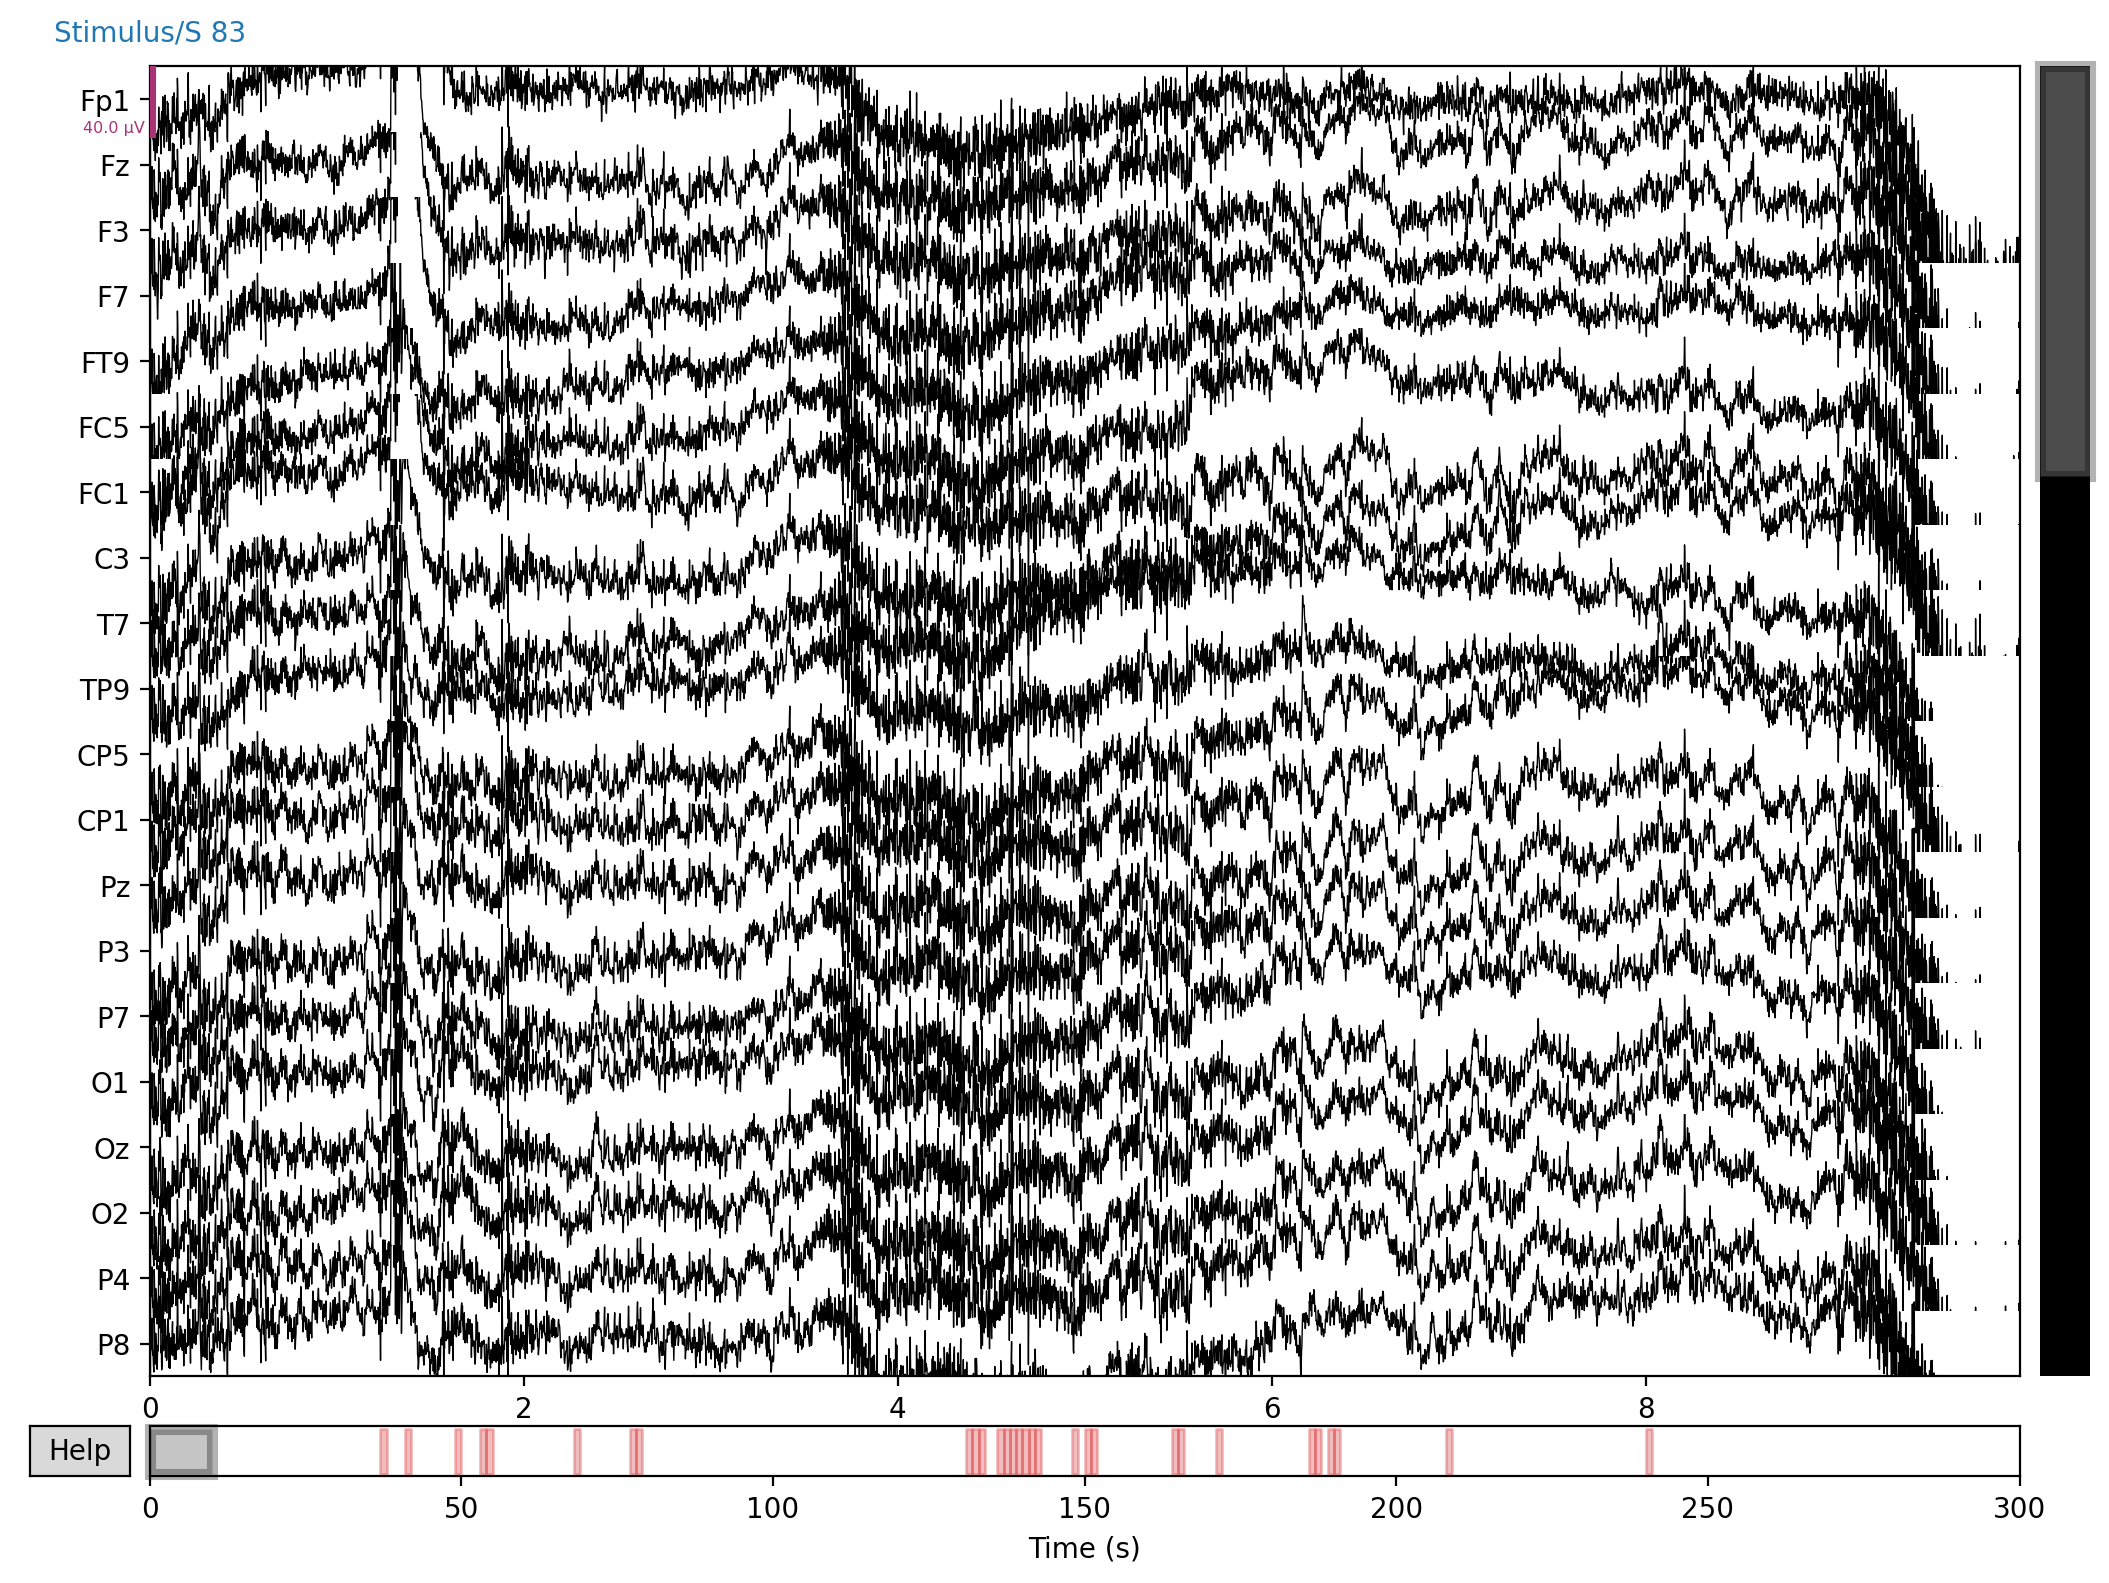

Channels marked as bad: none


In [146]:
raw.copy().crop(tmin=41.482, tmax=341.514).plot()

### 5. Save final epochs

Save the resting periods separately.

'1': resting before ASRT,
'2': resting after ASRT

#### 5.1. Resting period before ASRT

In [ ]:
fid = f'{raw.info["subject"]}_{raw.info["condition"]}_rs_{raw.info["num_day"]}_1'
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac_rs['1'].save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

#### 5.2. Resting period after ASRT

In [ ]:
fid = f'{raw.info["subject"]}_{raw.info["condition"]}_rs_{raw.info["num_day"]}_2'
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac_rs['2'].save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
del epochs_autoreject_rs, epochs_ransac_rs

## II. ASRT

Without manual intervention preprocessing Day1 or Day2 ASRT data takes 15 minutes.
Fingers crossed.

### Create folder for preprocessed files

In [ ]:
# Create path to interim epoch files
interim_epochs_path = os.path.join(interim_path, condition, 'epochs_asrt')
if not os.path.exists(interim_epochs_path):
    os.makedirs(interim_epochs_path)

# Create path to interim raw files
interim_raw_path = os.path.join(interim_path, condition, 'raw_asrt')
if not os.path.exists(interim_raw_path):
    os.makedirs(interim_raw_path)

### Crop raw data
#### 1. Sequence A

In [ ]:
events

In [ ]:
raw_asrt_seqA = concat_raws_from_events(events[events['sequence'] == 'A'], raw)

In [ ]:
events[events['sequence'] == 'A']

#### 2. Sequence B

In [ ]:
raw_asrt_seqB = concat_raws_from_events(events[events['sequence'] == 'B'], raw)

### Run ICA

Running ICA takes approximately 5 mins. Grab a coffee.

In [ ]:
ica, epochs_ica = run_ica(raw=raw_asrt_seqB)
ica.plot_sources(epochs_ica, start=0, stop=10)

In [ ]:
raw_asrt_seqA.plot()

In [ ]:
ica, epochs_ica = run_ica(raw=raw_asrt_seqA)
ica.plot_sources(epochs_ica, start=0, stop=10)

In [ ]:
ica.apply(epochs_ica)
epochs_ica.info['description'] = f'n_components: {len(ica.exclude)}'

In [ ]:
f'{subject}_{condition}_asrt_{num_day}'

In [ ]:
fid = f'{subject}_{condition}_asrt_{num_day}'
epochs_clean_fname = f'{fid}_ICA'
postfix = '-epo.fif.gz'
epochs_ica.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

#### Add annotations to raw data

In [ ]:
events = mne.make_fixed_length_events(raw_asrt_seqB,
                                  id=1,
                                  first_samp=True,
                                  duration=1.0,
                                  overlap=0.0)

start_times = [events[idx][0] / raw.info['sfreq'] for idx, value in enumerate(epochs_ica.drop_log) if 'FASTER' in value]
raw_asrt_seqB.annotations.append(onset=start_times,
                                  duration=[1.0] * len(start_times),
                                 description='BAD_auto')

In [ ]:
events = mne.make_fixed_length_events(raw_asrt_seqA,
                                  id=1,
                                  first_samp=True,
                                  duration=1.0,
                                  overlap=0.0)

start_times = [events[idx][0] / raw.info['sfreq'] for idx, value in enumerate(epochs_ica.drop_log) if 'FASTER' in value]
raw_asrt_seqA.annotations.append(onset=start_times,
                                  duration=[1.0] * len(start_times),
                                 description='BAD_auto')

In [ ]:
del epochs_ransac_rs_1, epochs_ransac_rs_2

### Run autoreject

Running automatic epoch rejection takes about 3 minutes. Drink some water. 

In [ ]:
epochs_autoreject = run_autoreject(epochs_ica, n_jobs=11, subset=True)

In [ ]:
epochs_autoreject.plot_drop_log()

In [ ]:
epochs_autoreject.plot()

In [ ]:
# save clean epochs
epochs_clean_fname = f'{fid}_ICA_autoreject'
postfix = '-epo.fif.gz'
epochs_autoreject.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
start_times = [events[idx][0] / raw.info['sfreq'] for idx, value in enumerate(epochs_autoreject.drop_log) if 'AUTOREJECT' in value]
raw_asrt_seqB.annotations.append(onset=start_times,
                                  duration=[1.0] * len(start_times),
                                 description='BAD_auto')

In [ ]:
start_times = [events[idx][0] / raw.info['sfreq'] for idx, value in enumerate(epochs_autoreject.drop_log) if 'AUTOREJECT' in value]
raw_asrt_seqA.annotations.append(onset=start_times,
                                  duration=[1.0] * len(start_times),
                                 description='BAD_auto')

### Run Ransac

In [ ]:
epochs_ransac = run_ransac(epochs_autoreject)

In [ ]:
epochs_ransac.info

In [ ]:
epochs_autoreject.info['bad_channels_autoreject']

In [ ]:
if epochs_autoreject.info['bad_channels_autoreject']:
    epochs_ransac.info.update(bads=epochs_autoreject.info['bad_channels_autoreject'])
    bads_str = ', '.join(epochs_ransac.info['bad_channels_autoreject'])
    epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)
    epochs_ransac.interpolate_bads()

epochs_ransac.set_eeg_reference()

In [ ]:
# save clean epochs
epochs_clean_fname = f'{fid}_ICA_autoreject_ransac'
postfix = '-epo.fif.gz'
epochs_ransac.save(os.path.join(interim_epochs_path, f'{epochs_clean_fname}{postfix}'), overwrite=True)

In [ ]:
fname = f'{fid}_seqB_annotated'
postfix = '-raw.fif.gz'
raw_asrt_seqB.save(os.path.join(interim_raw_path, f'{fname}{postfix}'), overwrite=True)

In [ ]:
fname = f'{fid}_seqA_annotated'
postfix = '-raw.fif.gz'
raw_asrt_seqA.save(os.path.join(interim_raw_path, f'{fname}{postfix}'), overwrite=True)

In [ ]:
epochs_ransac.plot(n_epochs=10)

In [ ]:
plt.close('all')